# Read this section importantly!

In [1]:
!nvidia-smi

Mon May  1 01:36:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Install some required libraries
# Feel free to add more if you want
!pip install -q python-levenshtein torchsummaryX

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.1/174.1 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 59.4 MB/s eta 0:00:00


In [3]:
pip install transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 64.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 60.2 MB/s eta 0:00:00


In [4]:
import torch
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchsummaryX import summary
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import torchvision.transforms as tvt
import torchaudio.transforms as tat
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import gc

import zipfile
import pandas as pd
from tqdm import tqdm
import os
import datetime

import warnings
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", DEVICE)

Device:  cuda
Device:  cuda


# Dataset and Dataloaders

In terms of the dataset, the dataset structure for HW3P2 and HW4P2 dataset are very similar. Can you spot out the differences? What all will be required?? 

Hints:

- Check how big is the dataset (do you require memory efficient loading techniques??)
- How do we load mfccs? Do we need to normalise them? 
- Does the data have \<SOS> and \<EOS> tokens in each sequences? Do we remove them or do we not remove them? (Read writeup)
- Would we want a collating function? Ask yourself: Why did we need a collate function last time?
- Observe the VOCAB, is the dataset same as HW3P2? 
- Should you add augmentations, if yes which augmentations? When should you add augmentations? (Check bootcamp for answer)


### **Stock Indicators**

In [79]:
def technical_indicators(df):
  df_close=df['Close']
  df_close=pd.DataFrame(df_close, columns=['Close'])
  df11=df_close.reset_index()
  #RSI
  df11['change'] = df11['Close'].diff()
  df['change']=df11['change']
    #SMA  #10days
  df11['SMA10'] = df11['Close'].rolling(10).mean()
  # df['delta']=(df['change']>0)*1.
  def rma(x, n):
      """Running moving average"""
      a = np.full_like(x, np.nan)
      a[n] = x[1:n+1].mean()
      for i in range(n+1, len(x)):
          a[i] = (a[i-1] * (n - 1) + x[i]) / n
      return a

  df11['gain'] = df11.change.mask(df11.change < 0, 0.0)
  df11['loss'] = -df11.change.mask(df11.change > 0, -0.0)
  df11['avg_gain'] = rma(df11.gain.to_numpy(), 14)        
  df11['avg_loss'] = rma(df11.loss.to_numpy(), 14)     
  df11['rs'] = df11.avg_gain / df11.avg_loss
  df11['rsi'] = 100 - (100 / (1 + df11.rs))


  ma = df['Close'].rolling(14).mean()
  df['disparity'] = ((df['Close'] - ma) / ma) * 1000

  df11.drop(columns=['Close','change','index','gain','loss','avg_gain','avg_loss','rs'], inplace=True)
  df_cat=pd.concat([df, df11], axis=1)
  df_cat.fillna(method='bfill', axis=0, inplace=True)
  df_cat.fillna(method='ffill', axis=0, inplace=True)
  return df_cat

dir=["AAPL","AXP","DIS","GS","IBM","MSFT","NKE","PG","QCOM","RTX"]
dfs=[]
for i in range(len(dir)):
  Stock = pd.read_csv(dir[i]+".csv").iloc[:2014]
  df=technical_indicators(Stock).drop(columns=['Date','Adj Close'])
  dfs.append(df)

assert(len(dfs)==len(dir))

FEATURE=dfs[0].shape[-1]
print(FEATURE)
dfs[0]

9


,Open,High,Low,Close,Volume,change,disparity,SMA10,rsi
0,7.622500,7.660714,7.585000,7.643214,493729600,0.013215,-57.804546,7.520571,38.882129
1,7.664286,7.699643,7.616071,7.656429,601904800,0.013215,-57.804546,7.520571,38.882129
2,7.656429,7.686786,7.526786,7.534643,552160000,-0.121786,-57.804546,7.520571,38.882129
3,7.562500,7.571429,7.466071,7.520714,477131200,-0.013929,-57.804546,7.520571,38.882129
4,7.510714,7.571429,7.466429,7.570714,447610800,0.050000,-57.804546,7.520571,38.882129
...,...,...,...,...,...,...,...,...,...
2009,42.700001,42.867500,42.419998,42.642502,132742000,-1.109997,-11.773520,43.401500,46.549485
2010,42.525002,42.695000,42.427502,42.650002,85992800,0.007500,-12.249650,43.374000,46.637994
2011,42.750000,42.962502,42.619999,42.770000,65920800,0.119998,-10.191011,43.344250,48.118296
2012,42.630001,42.647499,42.305000,42.307499,103999600,-0.462501,-20.837835,43.269500,43.149848


### **Standardize**

In [80]:
#Normalize time series
Scalers = [ StandardScaler() for _ in range(len(dfs)) ]

dfs_standard=[]
for i in range(len(dfs)):
  dataset_standard = Scalers[i].fit_transform(dfs[i])
  dfs_standard.append(dataset_standard)

print(dfs_standard[0])
print(dfs_standard[0].shape)

[[-1.61478997 -1.62166144 -1.60579011 ... -1.95815957 -1.62335813
  -1.22553955]
 [-1.61012308 -1.61733934 -1.6022995  ... -1.95815957 -1.62335813
  -1.22553955]
 [-1.61100059 -1.61876679 -1.61233004 ... -1.95815957 -1.62335813
  -1.22553955]
 ...
 [ 2.30844075  2.29772486  2.33014346 ... -0.48518865  2.39307592
  -0.53276435]
 [ 2.29503861  2.2627516   2.29475556 ... -0.8145585   2.38469518
  -0.90543171]
 [ 2.28498692  2.31021507  2.29587888 ... -0.26697789  2.37990218
  -0.24847818]]
(2014, 9)


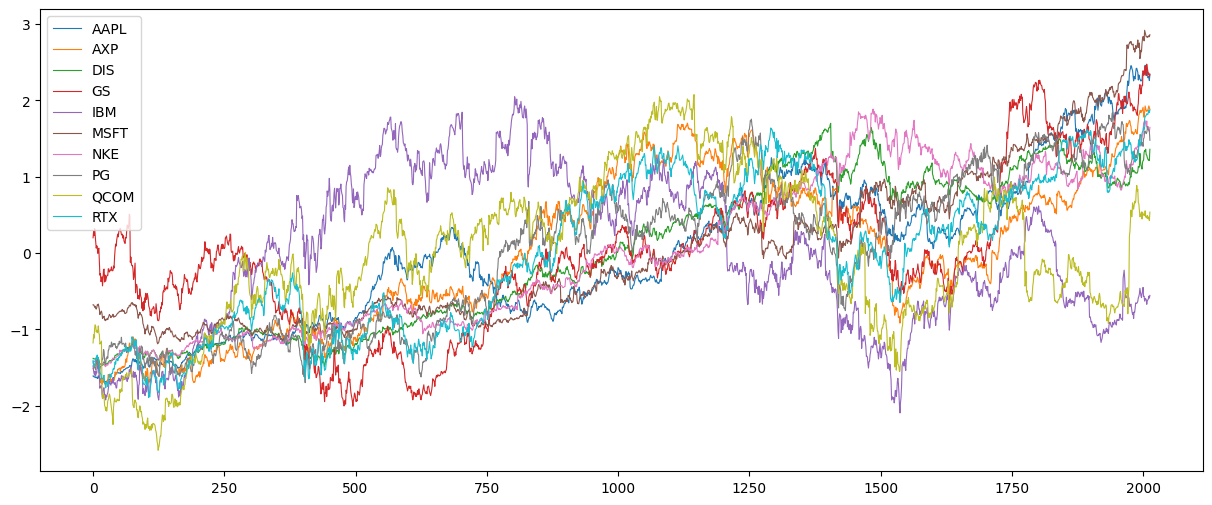

In [81]:
plt.figure(figsize=(15,6))
for i in range(len(dfs)):
  plt.plot(dfs_standard[i][:,3], linewidth=0.8, label=dir[i]) #plot closing price
plt.legend()

### **Concatenate**

In [82]:
print(np.array(dfs_standard).shape)
dfs_cat=np.concatenate(dfs_standard, axis=-1)
dfs_cat.shape

(10, 2014, 9)


(2014, 90)

### **Train-Test Split**

In [83]:
# dataset=np.array(APPL)
# X_train=[]
# X_test=[]
# for i in range(len(dfs)):
#   dataset=dfs_standard[i].tolist()
#   split=int(0.7*len(dataset))
#   X_train.append(dataset[0:split] )
#   X_test.append(dataset[split:] )

# print(len(X_train[0]))
# print(len(X_test[0]))

X=dfs_cat.tolist()
split=int(0.7*len(X))
X_train=X[0:split] 
X_test=X[split:] 

print(len(X_train))
print(len(X_test))

1409
605


In [84]:
#TODO: try to tune this
config = {
  'batch_size': 64,
  'lr':1e-4,
  'epochs': 30,
}

In [85]:
class TransformerDataset(Dataset):
    def __init__(self, data, indices, enc_seq_len, pred_seq_len) :
        super().__init__()
        self.data = data
        self.indices = indices
        self.enc_seq_len = enc_seq_len
        self.pred_seq_len = pred_seq_len

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, index):
        start, end = self.indices[index]

        sequence = self.data[start:end]

        src = sequence[:self.enc_seq_len]      #0~59 inclusive
        tgt = sequence[self.enc_seq_len-self.pred_seq_len+1 : self.enc_seq_len+1]     #56~60 inclusive
        true = sequence[self.enc_seq_len+1:]     #61~65 inclusive

        return src, tgt, true
    

In [86]:
def get_windows(data, window_size, step_size):
    start = 0
    end = window_size
    
    indices = []
    while end < len(data):      #proceed window by step size, count how many sequences 
        indices.append( (start, end) )
        start += step_size
        end += step_size
    return indices

torch.Size([128, 30, 90]) torch.Size([128, 10, 90])
x:  tensor([-0.3489, -0.2781,  0.3350,  0.5191,  0.6635,  0.2109,  0.4839,  0.6350,
         0.4662,  0.2616,  0.3171,  0.6087,  0.5478,  0.4312,  0.5068,  0.5014,
         0.7781,  1.3382,  1.2215,  1.4885,  1.2047,  1.0347,  1.4335,  1.8537,
         1.6971,  1.9476,  1.8117,  0.8002,  0.9554,  1.0915])
tgt:  tensor([1.0347, 1.4335, 1.8537, 1.6971, 1.9476, 1.8117, 0.8002, 0.9554, 1.0915,
        1.1356])
y_train:  tensor([ 1.1304,  0.8829,  1.0262,  0.8358,  0.7445,  0.8855,  0.9868,  1.1182,
         0.3575, -0.5065])


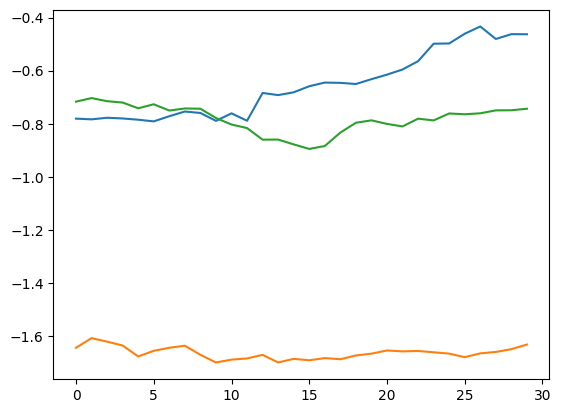

In [88]:
# Dataset Dataloader:
#TODO: tune context_len and pred_len
context_len=30
pred_len=10
window_size=context_len+pred_len+1
training_indices = get_windows(X_train, window_size, step_size=3) #TODO: Tune step size... 
val_indices = get_windows(X_test, window_size, step_size=1) #TODO: Tune step size... 
test_indices = get_windows(X, window_size, step_size=1) 

# print(training_indices)
train_data=TransformerDataset(torch.FloatTensor(X_train), training_indices, context_len, pred_len) 
val_data=TransformerDataset(torch.FloatTensor(X_test), val_indices, context_len, pred_len) 
test_data=TransformerDataset(torch.FloatTensor(X), test_indices, context_len, pred_len) 

train_loader = torch.utils.data.DataLoader(
    dataset     = train_data, 
    batch_size  = 128,
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset     = val_data, 
    batch_size  = 24,
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    dataset     = test_data, 
    batch_size  = 1,
    pin_memory  = False
)

for batch in train_loader: 
    src, tgt, y_train=batch
    print(src.shape, tgt.shape)
    print("x: ", src[0,:,-1])   #60 days context  
    print("tgt: ", tgt[0,:,-1]) #should be next five days 
    print("y_train: ", y_train[0,:,-1])  #True label should shift by one to right
    plt.plot(src[0,:,3])
    plt.plot(src[1,:,3])
    plt.plot(src[2,:,3]) #
    break

### **Positional Encoder and Transformer**

In [89]:
class PositionalEncoder(nn.Module):
    def __init__(self,  max_seq_len = 5000, d_model = 512, dropout= 0.1,):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        time = torch.arange(0, max_seq_len).unsqueeze(1)
        self.positional_encoding = torch.zeros(1,max_seq_len, d_model).to(DEVICE)
        xx= (torch.arange(0,max_seq_len).reshape(-1, 1).to(DEVICE)) / torch.pow(10000, torch.arange(0, d_model, 2)/d_model).to(DEVICE)
        self.positional_encoding[:, :, 0::2] = torch.sin(xx)
        self.positional_encoding[:, :, 1::2] = torch.cos(xx)

        self.register_buffer('pe', self.positional_encoding)

    def forward(self, x) :
        x = x + self.positional_encoding[:,:x.shape[1]]
        x=self.dropout(x)
        return x


In [90]:
class Transformer(nn.Module):
    def __init__(self, input_dim=8, output_dim=1, d_model=512, nhead=8, num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=2048, dropout=0.1,encode_seq_len=60,pred_seq_len=10):
        super(Transformer, self).__init__()
        self.nhead=nhead
        self.d_model=d_model
        self.encode_seq_len=encode_seq_len
        self.embedding = nn.Linear(input_dim, d_model) 
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        self.pred_seq_len=pred_seq_len
        self.linear_out = nn.Linear(d_model, output_dim)
        self.positional_encoding_layer = PositionalEncoder(encode_seq_len, d_model, dropout  )

    def forward(self, x, query, src_mask=None, tgt_mask=None):
        # print("in,",x.shape) #32 10 29, batch len feature
        batch_size, seq_len, feature=x.shape

        # #encode x
        x = self.embedding(x) 
        x = self.positional_encoding_layer(x)

        #encode query
        query=self.embedding(query) 

        encoder_out = self.encoder(x)
        decoder_out = self.decoder(query, encoder_out,tgt_mask=tgt_mask, memory_mask=src_mask )
        # print("asdasdasdasdasd",decoder_out.shape)

        # attn_weights = self.decoder.layers[-1].multihead_attn.attn_output_weights

        decoder_out = self.linear_out(decoder_out)
        
        return decoder_out


In [91]:
gc.collect()
torch.cuda.empty_cache()
len(dir)

10

In [92]:
#TODO: tune model parameters
model=Transformer(input_dim=dfs_cat.shape[-1], output_dim=len(dir), d_model=512, nhead=2, 
                  num_encoder_layers=4, num_decoder_layers=4, dim_feedforward=512, 
                  dropout=0.4, encode_seq_len=context_len, pred_seq_len=pred_len).to(device)
# print(x.size)
for x, y,z in train_loader: 
    x=torch.FloatTensor(x).to(device)
    y=torch.FloatTensor(y).to(device)
    out=model(x,y)
    print("x shape:", x.shape, "y shape:", y.shape)
    print("out shape:", out.shape)
    # summary(model, x1)
    break
print("context len:",model.encode_seq_len,"pred_len:", model.pred_seq_len)

x shape: torch.Size([128, 30, 90]) y shape: torch.Size([128, 10, 90])
out shape: torch.Size([128, 10, 10])
context len: 30 pred_len: 10


# Model Setup 

# Loss Function, Optimizers, Scheduler

In [93]:
optimizer   = torch.optim.Adam(model.parameters(), lr= config['lr'])
criterion   = torch.nn.SmoothL1Loss() 
scaler      = torch.cuda.amp.GradScaler()

# Optional (but Recommended): Create a custom class for a Teacher Force Schedule

# Train and Validation functions 


In [94]:
class Trainer():
  def __init__(self, model, loader, optimizer, criterion, scheduler, val_loader):
    self.model      = model
    self.loader     = loader
    self.optimizer  = optimizer
    self.criterion  = criterion
    self.train_plot=[]
    self.teacher=True
    self.val_loader=val_loader
    
  def train(self, teacher_forcing_rate):
      self.model.train() # set to training mode
      self.model.to(device)

      batch_bar = tqdm(total=len(self.loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      running_loss        = 0.0

      for i, batch in enumerate(self.loader):
          self.optimizer.zero_grad()

          src, trg, y_train = batch

          src = src.to(device)
          trg = trg.to(device)
          y_train = y_train.to(device)

          batch_size = src.shape[0]


          y_pred = self.model(src, trg, src_mask=None, tgt_mask=None)

          #0,'Open',1,'High',2,'Low',3,'Close',4,'Volume'
          pred_what=3
          y_train_list=[]
          for j in range(len(dir)):
            y_train_list.append(y_train[:,:, pred_what + FEATURE *j ] )    #get Closing of each stocks
          
          y_trains=torch.stack(y_train_list, axis=-1).to(device)  #128, 7, 10
          # print(y_pred.shape)

          loss = criterion(y_pred, y_trains)    #TODO: try changing 8 to others, if want the model to learn other columns
          
          loss.backward()
          torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1e+6)
          optimizer.step()
          
          self.train_plot.append(loss.item())
          running_loss += loss.item()
          
          batch_bar.set_postfix(
              loss="{:.04f}".format(running_loss/(i+1)),
              lr="{:.04f}".format(float(self.optimizer.param_groups[0]['lr'])),
              # teacher_time="{:.04f}".format(teach/10)
               )
          batch_bar.update()

          del src, trg, y_train
          torch.cuda.empty_cache()

      batch_bar.close()

      return running_loss/len(self.loader)

  def validate(self):
      self.model.eval() # set to training mode
      self.model.to(device)

      batch_bar = tqdm(total=len(self.loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      running_loss        = 0.0

      for i, batch in enumerate(self.val_loader):
          self.optimizer.zero_grad()

          src, trg, y_test = batch

          src = src.to(device)
          trg = trg.to(device)
          y_test = y_test.to(device)

          batch_size = src.shape[0]

          y_pred = self.model(src, trg, src_mask=None, tgt_mask=None)

          # #0,'Time',1,'Open',2,'High',3,'Low',4,'Close',5,'Volume',6,'change',7,'delta',8,'Moving Average'
          # pred_what=3
          # # print(y_pred[:,1].shape,y_test[:,1,pred_what].shape)
          # val_loss = criterion(y_pred[:,0], y_test[:,0,pred_what].reshape(-1,1))    #TODO: try changing 8 to others, if want the model to learn other columns
          pred_what=3
          y_test_list=[]
          for j in range(len(dir)):
            y_test_list.append(y_test[:,:, pred_what + FEATURE *j ] )    #get Closing of each stocks
          
          y_tests=torch.stack(y_test_list, axis=-1).to(device)  #128, 7, 10

          val_loss = criterion(y_pred, y_tests)    #TODO: try changing 8 to others, if want the model to learn other columns
          
          running_loss += val_loss.item()
          
          batch_bar.set_postfix(
              loss="{:.04f}".format(running_loss/(i+1))
               )
          batch_bar.update()

          del src, trg, y_test
          torch.cuda.empty_cache()

      batch_bar.close()

      return running_loss/len(self.loader)

  def test(self, test_loader):
        self.model.eval() # set to training mode
        self.model.to(device)
        batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
        prediction=[]
        for i, batch in enumerate(test_loader):
            self.optimizer.zero_grad()

            src, trg, y_test = batch

            src = src.to(device)
            trg = trg.to(device)

            batch_size = src.shape[0]


            y_pred = self.model(src, trg, src_mask=None, tgt_mask=None)

            prediction.append(y_pred)

            del src, trg, y_test
            torch.cuda.empty_cache()
            batch_bar.update()

        batch_bar.close()

        return prediction

In [95]:
gc.collect()
torch.cuda.empty_cache()

In [96]:
scheduler   = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.995)
trainer=Trainer(model, train_loader, optimizer, criterion,  scheduler, val_loader=val_loader)


Epoch: 1/300


	Train Loss 0.2924	 Learning Rate 0.0001000	 Validation Loss 2.1226

Epoch: 2/300


	Train Loss 0.1061	 Learning Rate 0.0000995	 Validation Loss 1.4842

Epoch: 3/300


	Train Loss 0.0892	 Learning Rate 0.0000990	 Validation Loss 1.9535

Epoch: 4/300


	Train Loss 0.0703	 Learning Rate 0.0000985	 Validation Loss 1.5650

Epoch: 5/300


	Train Loss 0.0605	 Learning Rate 0.0000980	 Validation Loss 1.1736

Epoch: 6/300


	Train Loss 0.0549	 Learning Rate 0.0000975	 Validation Loss 1.1835

Epoch: 7/300


	Train Loss 0.0512	 Learning Rate 0.0000970	 Validation Loss 1.0847

Epoch: 8/300


	Train Loss 0.0470	 Learning Rate 0.0000966	 Validation Loss 1.0290

Epoch: 9/300


	Train Loss 0.0448	 Learning Rate 0.0000961	 Validation Loss 0.9730

Epoch: 10/300


	Train Loss 0.0420	 Learning Rate 0.0000956	 Validation Loss 0.9274

Epoch: 11/300


	Train Loss 0.0404	 Learning Rate 0.0000951	 Validation Loss 0.9833

Epoch: 12/300


	Train Loss 0.0385	 Learning Rate 0.0000946	 Validation Loss 0.9237

Epoch: 13/300


	Train Loss 0.0372	 Learning Rate 0.0000942	 Validation Loss 0.9295

Epoch: 14/300


	Train Loss 0.0361	 Learning Rate 0.0000937	 Validation Loss 0.9012

Epoch: 15/300


	Train Loss 0.0341	 Learning Rate 0.0000932	 Validation Loss 0.8972

Epoch: 16/300


	Train Loss 0.0335	 Learning Rate 0.0000928	 Validation Loss 0.8647

Epoch: 17/300


	Train Loss 0.0326	 Learning Rate 0.0000923	 Validation Loss 0.8657

Epoch: 18/300


	Train Loss 0.0315	 Learning Rate 0.0000918	 Validation Loss 0.8531

Epoch: 19/300


	Train Loss 0.0310	 Learning Rate 0.0000914	 Validation Loss 0.8646

Epoch: 20/300


	Train Loss 0.0306	 Learning Rate 0.0000909	 Validation Loss 0.8636

Epoch: 21/300


	Train Loss 0.0298	 Learning Rate 0.0000905	 Validation Loss 0.8734

Epoch: 22/300


	Train Loss 0.0285	 Learning Rate 0.0000900	 Validation Loss 0.8459

Epoch: 23/300


	Train Loss 0.0285	 Learning Rate 0.0000896	 Validation Loss 0.8085

Epoch: 24/300


	Train Loss 0.0283	 Learning Rate 0.0000891	 Validation Loss 0.8550

Epoch: 25/300


	Train Loss 0.0283	 Learning Rate 0.0000887	 Validation Loss 0.8242

Epoch: 26/300


	Train Loss 0.0270	 Learning Rate 0.0000882	 Validation Loss 0.8365

Epoch: 27/300


	Train Loss 0.0266	 Learning Rate 0.0000878	 Validation Loss 0.8361

Epoch: 28/300


	Train Loss 0.0257	 Learning Rate 0.0000873	 Validation Loss 0.7959

Epoch: 29/300


	Train Loss 0.0257	 Learning Rate 0.0000869	 Validation Loss 0.8595

Epoch: 30/300


	Train Loss 0.0253	 Learning Rate 0.0000865	 Validation Loss 0.8296

Epoch: 31/300


	Train Loss 0.0247	 Learning Rate 0.0000860	 Validation Loss 0.8111

Epoch: 32/300


	Train Loss 0.0246	 Learning Rate 0.0000856	 Validation Loss 0.8373

Epoch: 33/300


	Train Loss 0.0243	 Learning Rate 0.0000852	 Validation Loss 0.8096

Epoch: 34/300


	Train Loss 0.0240	 Learning Rate 0.0000848	 Validation Loss 0.8004

Epoch: 35/300


	Train Loss 0.0236	 Learning Rate 0.0000843	 Validation Loss 0.8073

Epoch: 36/300


	Train Loss 0.0231	 Learning Rate 0.0000839	 Validation Loss 0.7954

Epoch: 37/300


	Train Loss 0.0233	 Learning Rate 0.0000835	 Validation Loss 0.8142

Epoch: 38/300


	Train Loss 0.0225	 Learning Rate 0.0000831	 Validation Loss 0.8167

Epoch: 39/300


	Train Loss 0.0227	 Learning Rate 0.0000827	 Validation Loss 0.8088

Epoch: 40/300


	Train Loss 0.0224	 Learning Rate 0.0000822	 Validation Loss 0.8240

Epoch: 41/300


	Train Loss 0.0222	 Learning Rate 0.0000818	 Validation Loss 0.7885

Epoch: 42/300


	Train Loss 0.0221	 Learning Rate 0.0000814	 Validation Loss 0.8130

Epoch: 43/300


	Train Loss 0.0215	 Learning Rate 0.0000810	 Validation Loss 0.8441

Epoch: 44/300


	Train Loss 0.0214	 Learning Rate 0.0000806	 Validation Loss 0.7883

Epoch: 45/300


	Train Loss 0.0209	 Learning Rate 0.0000802	 Validation Loss 0.8135

Epoch: 46/300


	Train Loss 0.0209	 Learning Rate 0.0000798	 Validation Loss 0.8189

Epoch: 47/300


	Train Loss 0.0208	 Learning Rate 0.0000794	 Validation Loss 0.8286

Epoch: 48/300


	Train Loss 0.0202	 Learning Rate 0.0000790	 Validation Loss 0.8100

Epoch: 49/300


	Train Loss 0.0201	 Learning Rate 0.0000786	 Validation Loss 0.8028

Epoch: 50/300


	Train Loss 0.0197	 Learning Rate 0.0000782	 Validation Loss 0.8276

Epoch: 51/300


	Train Loss 0.0196	 Learning Rate 0.0000778	 Validation Loss 0.7984

Epoch: 52/300


	Train Loss 0.0193	 Learning Rate 0.0000774	 Validation Loss 0.8265

Epoch: 53/300


	Train Loss 0.0194	 Learning Rate 0.0000771	 Validation Loss 0.8493

Epoch: 54/300


	Train Loss 0.0192	 Learning Rate 0.0000767	 Validation Loss 0.8094

Epoch: 55/300


	Train Loss 0.0191	 Learning Rate 0.0000763	 Validation Loss 0.7919

Epoch: 56/300


	Train Loss 0.0186	 Learning Rate 0.0000759	 Validation Loss 0.8712

Epoch: 57/300


	Train Loss 0.0185	 Learning Rate 0.0000755	 Validation Loss 0.8380

Epoch: 58/300


	Train Loss 0.0186	 Learning Rate 0.0000751	 Validation Loss 0.7733

Epoch: 59/300


	Train Loss 0.0184	 Learning Rate 0.0000748	 Validation Loss 0.8151

Epoch: 60/300


	Train Loss 0.0179	 Learning Rate 0.0000744	 Validation Loss 0.8341

Epoch: 61/300


	Train Loss 0.0180	 Learning Rate 0.0000740	 Validation Loss 0.8069

Epoch: 62/300


	Train Loss 0.0178	 Learning Rate 0.0000737	 Validation Loss 0.8061

Epoch: 63/300


	Train Loss 0.0174	 Learning Rate 0.0000733	 Validation Loss 0.8155

Epoch: 64/300


	Train Loss 0.0170	 Learning Rate 0.0000729	 Validation Loss 0.8163

Epoch: 65/300


	Train Loss 0.0176	 Learning Rate 0.0000726	 Validation Loss 0.8148

Epoch: 66/300


	Train Loss 0.0172	 Learning Rate 0.0000722	 Validation Loss 0.8177

Epoch: 67/300


	Train Loss 0.0170	 Learning Rate 0.0000718	 Validation Loss 0.7934

Epoch: 68/300


	Train Loss 0.0168	 Learning Rate 0.0000715	 Validation Loss 0.8185

Epoch: 69/300


	Train Loss 0.0170	 Learning Rate 0.0000711	 Validation Loss 0.7916

Epoch: 70/300


	Train Loss 0.0165	 Learning Rate 0.0000708	 Validation Loss 0.8133

Epoch: 71/300


	Train Loss 0.0163	 Learning Rate 0.0000704	 Validation Loss 0.8236

Epoch: 72/300


	Train Loss 0.0163	 Learning Rate 0.0000701	 Validation Loss 0.7865

Epoch: 73/300


	Train Loss 0.0161	 Learning Rate 0.0000697	 Validation Loss 0.7987

Epoch: 74/300


	Train Loss 0.0163	 Learning Rate 0.0000694	 Validation Loss 0.8000

Epoch: 75/300


	Train Loss 0.0159	 Learning Rate 0.0000690	 Validation Loss 0.8288

Epoch: 76/300


	Train Loss 0.0157	 Learning Rate 0.0000687	 Validation Loss 0.8308

Epoch: 77/300


	Train Loss 0.0158	 Learning Rate 0.0000683	 Validation Loss 0.8394

Epoch: 78/300


	Train Loss 0.0155	 Learning Rate 0.0000680	 Validation Loss 0.8111

Epoch: 79/300


	Train Loss 0.0156	 Learning Rate 0.0000676	 Validation Loss 0.8145

Epoch: 80/300


	Train Loss 0.0155	 Learning Rate 0.0000673	 Validation Loss 0.8283

Epoch: 81/300


	Train Loss 0.0152	 Learning Rate 0.0000670	 Validation Loss 0.8018

Epoch: 82/300


	Train Loss 0.0152	 Learning Rate 0.0000666	 Validation Loss 0.8084

Epoch: 83/300


	Train Loss 0.0153	 Learning Rate 0.0000663	 Validation Loss 0.8119

Epoch: 84/300


	Train Loss 0.0149	 Learning Rate 0.0000660	 Validation Loss 0.8201

Epoch: 85/300


	Train Loss 0.0151	 Learning Rate 0.0000656	 Validation Loss 0.8013

Epoch: 86/300


	Train Loss 0.0148	 Learning Rate 0.0000653	 Validation Loss 0.8334

Epoch: 87/300


	Train Loss 0.0149	 Learning Rate 0.0000650	 Validation Loss 0.8203

Epoch: 88/300


	Train Loss 0.0150	 Learning Rate 0.0000647	 Validation Loss 0.8074

Epoch: 89/300


	Train Loss 0.0148	 Learning Rate 0.0000643	 Validation Loss 0.8272

Epoch: 90/300


	Train Loss 0.0148	 Learning Rate 0.0000640	 Validation Loss 0.8450

Epoch: 91/300


	Train Loss 0.0144	 Learning Rate 0.0000637	 Validation Loss 0.8287

Epoch: 92/300


	Train Loss 0.0146	 Learning Rate 0.0000634	 Validation Loss 0.8289

Epoch: 93/300


	Train Loss 0.0144	 Learning Rate 0.0000631	 Validation Loss 0.8323

Epoch: 94/300


	Train Loss 0.0140	 Learning Rate 0.0000627	 Validation Loss 0.8207

Epoch: 95/300


	Train Loss 0.0142	 Learning Rate 0.0000624	 Validation Loss 0.8274

Epoch: 96/300


	Train Loss 0.0136	 Learning Rate 0.0000621	 Validation Loss 0.8427

Epoch: 97/300


	Train Loss 0.0140	 Learning Rate 0.0000618	 Validation Loss 0.8159

Epoch: 98/300


	Train Loss 0.0137	 Learning Rate 0.0000615	 Validation Loss 0.8456

Epoch: 99/300


	Train Loss 0.0140	 Learning Rate 0.0000612	 Validation Loss 0.8348

Epoch: 100/300


	Train Loss 0.0135	 Learning Rate 0.0000609	 Validation Loss 0.8227

Epoch: 101/300


	Train Loss 0.0136	 Learning Rate 0.0000606	 Validation Loss 0.8322

Epoch: 102/300


	Train Loss 0.0135	 Learning Rate 0.0000603	 Validation Loss 0.8346

Epoch: 103/300


	Train Loss 0.0132	 Learning Rate 0.0000600	 Validation Loss 0.8284

Epoch: 104/300


	Train Loss 0.0133	 Learning Rate 0.0000597	 Validation Loss 0.8149

Epoch: 105/300


	Train Loss 0.0133	 Learning Rate 0.0000594	 Validation Loss 0.8358

Epoch: 106/300


	Train Loss 0.0133	 Learning Rate 0.0000591	 Validation Loss 0.8363

Epoch: 107/300


	Train Loss 0.0131	 Learning Rate 0.0000588	 Validation Loss 0.8207

Epoch: 108/300


	Train Loss 0.0129	 Learning Rate 0.0000585	 Validation Loss 0.8313

Epoch: 109/300


	Train Loss 0.0130	 Learning Rate 0.0000582	 Validation Loss 0.8232

Epoch: 110/300


	Train Loss 0.0129	 Learning Rate 0.0000579	 Validation Loss 0.8239

Epoch: 111/300


	Train Loss 0.0128	 Learning Rate 0.0000576	 Validation Loss 0.8368

Epoch: 112/300


	Train Loss 0.0130	 Learning Rate 0.0000573	 Validation Loss 0.8197

Epoch: 113/300


	Train Loss 0.0128	 Learning Rate 0.0000570	 Validation Loss 0.8154

Epoch: 114/300


	Train Loss 0.0128	 Learning Rate 0.0000568	 Validation Loss 0.8310

Epoch: 115/300


	Train Loss 0.0127	 Learning Rate 0.0000565	 Validation Loss 0.8126

Epoch: 116/300


	Train Loss 0.0124	 Learning Rate 0.0000562	 Validation Loss 0.8084

Epoch: 117/300


	Train Loss 0.0124	 Learning Rate 0.0000559	 Validation Loss 0.8445

Epoch: 118/300


	Train Loss 0.0126	 Learning Rate 0.0000556	 Validation Loss 0.8323

Epoch: 119/300


	Train Loss 0.0124	 Learning Rate 0.0000554	 Validation Loss 0.8241

Epoch: 120/300


	Train Loss 0.0122	 Learning Rate 0.0000551	 Validation Loss 0.8124

Epoch: 121/300


	Train Loss 0.0122	 Learning Rate 0.0000548	 Validation Loss 0.8248

Epoch: 122/300


	Train Loss 0.0120	 Learning Rate 0.0000545	 Validation Loss 0.8213

Epoch: 123/300


	Train Loss 0.0120	 Learning Rate 0.0000543	 Validation Loss 0.8246

Epoch: 124/300


	Train Loss 0.0120	 Learning Rate 0.0000540	 Validation Loss 0.8271

Epoch: 125/300


	Train Loss 0.0121	 Learning Rate 0.0000537	 Validation Loss 0.8273

Epoch: 126/300


	Train Loss 0.0121	 Learning Rate 0.0000534	 Validation Loss 0.8233

Epoch: 127/300


	Train Loss 0.0120	 Learning Rate 0.0000532	 Validation Loss 0.8234

Epoch: 128/300


	Train Loss 0.0119	 Learning Rate 0.0000529	 Validation Loss 0.8153

Epoch: 129/300


	Train Loss 0.0117	 Learning Rate 0.0000526	 Validation Loss 0.8336

Epoch: 130/300


	Train Loss 0.0120	 Learning Rate 0.0000524	 Validation Loss 0.8244

Epoch: 131/300


	Train Loss 0.0118	 Learning Rate 0.0000521	 Validation Loss 0.8157

Epoch: 132/300


	Train Loss 0.0117	 Learning Rate 0.0000519	 Validation Loss 0.8230

Epoch: 133/300


	Train Loss 0.0117	 Learning Rate 0.0000516	 Validation Loss 0.8371

Epoch: 134/300


	Train Loss 0.0116	 Learning Rate 0.0000513	 Validation Loss 0.8125

Epoch: 135/300


	Train Loss 0.0116	 Learning Rate 0.0000511	 Validation Loss 0.8400

Epoch: 136/300


	Train Loss 0.0117	 Learning Rate 0.0000508	 Validation Loss 0.8242

Epoch: 137/300


	Train Loss 0.0114	 Learning Rate 0.0000506	 Validation Loss 0.8477

Epoch: 138/300


	Train Loss 0.0116	 Learning Rate 0.0000503	 Validation Loss 0.8348

Epoch: 139/300


	Train Loss 0.0113	 Learning Rate 0.0000501	 Validation Loss 0.8376

Epoch: 140/300


	Train Loss 0.0115	 Learning Rate 0.0000498	 Validation Loss 0.8293

Epoch: 141/300


	Train Loss 0.0115	 Learning Rate 0.0000496	 Validation Loss 0.8115

Epoch: 142/300


	Train Loss 0.0114	 Learning Rate 0.0000493	 Validation Loss 0.8514

Epoch: 143/300


	Train Loss 0.0113	 Learning Rate 0.0000491	 Validation Loss 0.8442

Epoch: 144/300


	Train Loss 0.0112	 Learning Rate 0.0000488	 Validation Loss 0.8165

Epoch: 145/300


	Train Loss 0.0113	 Learning Rate 0.0000486	 Validation Loss 0.8467

Epoch: 146/300


	Train Loss 0.0111	 Learning Rate 0.0000483	 Validation Loss 0.8357

Epoch: 147/300


	Train Loss 0.0112	 Learning Rate 0.0000481	 Validation Loss 0.8230

Epoch: 148/300


	Train Loss 0.0111	 Learning Rate 0.0000479	 Validation Loss 0.8380

Epoch: 149/300


	Train Loss 0.0112	 Learning Rate 0.0000476	 Validation Loss 0.8300

Epoch: 150/300


	Train Loss 0.0112	 Learning Rate 0.0000474	 Validation Loss 0.8423

Epoch: 151/300


	Train Loss 0.0111	 Learning Rate 0.0000471	 Validation Loss 0.8220

Epoch: 152/300


	Train Loss 0.0111	 Learning Rate 0.0000469	 Validation Loss 0.8282

Epoch: 153/300


	Train Loss 0.0108	 Learning Rate 0.0000467	 Validation Loss 0.8362

Epoch: 154/300


	Train Loss 0.0109	 Learning Rate 0.0000464	 Validation Loss 0.8170

Epoch: 155/300


	Train Loss 0.0107	 Learning Rate 0.0000462	 Validation Loss 0.8551

Epoch: 156/300


	Train Loss 0.0109	 Learning Rate 0.0000460	 Validation Loss 0.8388

Epoch: 157/300


	Train Loss 0.0107	 Learning Rate 0.0000458	 Validation Loss 0.8474

Epoch: 158/300


	Train Loss 0.0108	 Learning Rate 0.0000455	 Validation Loss 0.8475

Epoch: 159/300


	Train Loss 0.0108	 Learning Rate 0.0000453	 Validation Loss 0.8362

Epoch: 160/300


	Train Loss 0.0107	 Learning Rate 0.0000451	 Validation Loss 0.8301

Epoch: 161/300


	Train Loss 0.0108	 Learning Rate 0.0000448	 Validation Loss 0.8309

Epoch: 162/300


	Train Loss 0.0107	 Learning Rate 0.0000446	 Validation Loss 0.8523

Epoch: 163/300


	Train Loss 0.0107	 Learning Rate 0.0000444	 Validation Loss 0.8291

Epoch: 164/300


	Train Loss 0.0107	 Learning Rate 0.0000442	 Validation Loss 0.8436

Epoch: 165/300


	Train Loss 0.0105	 Learning Rate 0.0000440	 Validation Loss 0.8525

Epoch: 166/300


	Train Loss 0.0105	 Learning Rate 0.0000437	 Validation Loss 0.8427

Epoch: 167/300


	Train Loss 0.0103	 Learning Rate 0.0000435	 Validation Loss 0.8388

Epoch: 168/300


	Train Loss 0.0105	 Learning Rate 0.0000433	 Validation Loss 0.8371

Epoch: 169/300


	Train Loss 0.0102	 Learning Rate 0.0000431	 Validation Loss 0.8553

Epoch: 170/300


	Train Loss 0.0104	 Learning Rate 0.0000429	 Validation Loss 0.8335

Epoch: 171/300


	Train Loss 0.0105	 Learning Rate 0.0000427	 Validation Loss 0.8498

Epoch: 172/300


	Train Loss 0.0106	 Learning Rate 0.0000424	 Validation Loss 0.8569

Epoch: 173/300


	Train Loss 0.0101	 Learning Rate 0.0000422	 Validation Loss 0.8519

Epoch: 174/300


	Train Loss 0.0103	 Learning Rate 0.0000420	 Validation Loss 0.8550

Epoch: 175/300


	Train Loss 0.0101	 Learning Rate 0.0000418	 Validation Loss 0.8534

Epoch: 176/300


	Train Loss 0.0102	 Learning Rate 0.0000416	 Validation Loss 0.8478

Epoch: 177/300


	Train Loss 0.0104	 Learning Rate 0.0000414	 Validation Loss 0.8522

Epoch: 178/300


	Train Loss 0.0102	 Learning Rate 0.0000412	 Validation Loss 0.8429

Epoch: 179/300


	Train Loss 0.0101	 Learning Rate 0.0000410	 Validation Loss 0.8528

Epoch: 180/300


	Train Loss 0.0100	 Learning Rate 0.0000408	 Validation Loss 0.8473

Epoch: 181/300


	Train Loss 0.0100	 Learning Rate 0.0000406	 Validation Loss 0.8511

Epoch: 182/300


	Train Loss 0.0100	 Learning Rate 0.0000404	 Validation Loss 0.8429

Epoch: 183/300


	Train Loss 0.0098	 Learning Rate 0.0000402	 Validation Loss 0.8576

Epoch: 184/300


	Train Loss 0.0099	 Learning Rate 0.0000400	 Validation Loss 0.8435

Epoch: 185/300


	Train Loss 0.0099	 Learning Rate 0.0000398	 Validation Loss 0.8584

Epoch: 186/300


	Train Loss 0.0101	 Learning Rate 0.0000396	 Validation Loss 0.8392

Epoch: 187/300


	Train Loss 0.0099	 Learning Rate 0.0000394	 Validation Loss 0.8355

Epoch: 188/300


	Train Loss 0.0098	 Learning Rate 0.0000392	 Validation Loss 0.8443

Epoch: 189/300


	Train Loss 0.0100	 Learning Rate 0.0000390	 Validation Loss 0.8478

Epoch: 190/300


	Train Loss 0.0099	 Learning Rate 0.0000388	 Validation Loss 0.8540

Epoch: 191/300


	Train Loss 0.0098	 Learning Rate 0.0000386	 Validation Loss 0.8431

Epoch: 192/300


	Train Loss 0.0098	 Learning Rate 0.0000384	 Validation Loss 0.8543

Epoch: 193/300


	Train Loss 0.0098	 Learning Rate 0.0000382	 Validation Loss 0.8382

Epoch: 194/300


	Train Loss 0.0098	 Learning Rate 0.0000380	 Validation Loss 0.8430

Epoch: 195/300


	Train Loss 0.0098	 Learning Rate 0.0000378	 Validation Loss 0.8342

Epoch: 196/300


	Train Loss 0.0099	 Learning Rate 0.0000376	 Validation Loss 0.8432

Epoch: 197/300


	Train Loss 0.0097	 Learning Rate 0.0000374	 Validation Loss 0.8530

Epoch: 198/300


	Train Loss 0.0099	 Learning Rate 0.0000373	 Validation Loss 0.8488

Epoch: 199/300


	Train Loss 0.0098	 Learning Rate 0.0000371	 Validation Loss 0.8536

Epoch: 200/300


	Train Loss 0.0097	 Learning Rate 0.0000369	 Validation Loss 0.8331

Epoch: 201/300


	Train Loss 0.0097	 Learning Rate 0.0000367	 Validation Loss 0.8486

Epoch: 202/300


	Train Loss 0.0096	 Learning Rate 0.0000365	 Validation Loss 0.8310

Epoch: 203/300


	Train Loss 0.0094	 Learning Rate 0.0000363	 Validation Loss 0.8431

Epoch: 204/300


	Train Loss 0.0096	 Learning Rate 0.0000361	 Validation Loss 0.8425

Epoch: 205/300


	Train Loss 0.0095	 Learning Rate 0.0000360	 Validation Loss 0.8415

Epoch: 206/300


	Train Loss 0.0094	 Learning Rate 0.0000358	 Validation Loss 0.8402

Epoch: 207/300


	Train Loss 0.0095	 Learning Rate 0.0000356	 Validation Loss 0.8462

Epoch: 208/300


	Train Loss 0.0096	 Learning Rate 0.0000354	 Validation Loss 0.8391

Epoch: 209/300


	Train Loss 0.0095	 Learning Rate 0.0000353	 Validation Loss 0.8567

Epoch: 210/300


	Train Loss 0.0094	 Learning Rate 0.0000351	 Validation Loss 0.8649

Epoch: 211/300


	Train Loss 0.0096	 Learning Rate 0.0000349	 Validation Loss 0.8510

Epoch: 212/300


	Train Loss 0.0094	 Learning Rate 0.0000347	 Validation Loss 0.8506

Epoch: 213/300


	Train Loss 0.0095	 Learning Rate 0.0000346	 Validation Loss 0.8412

Epoch: 214/300


	Train Loss 0.0093	 Learning Rate 0.0000344	 Validation Loss 0.8462

Epoch: 215/300


	Train Loss 0.0092	 Learning Rate 0.0000342	 Validation Loss 0.8608

Epoch: 216/300


	Train Loss 0.0093	 Learning Rate 0.0000340	 Validation Loss 0.8480

Epoch: 217/300


	Train Loss 0.0093	 Learning Rate 0.0000339	 Validation Loss 0.8459

Epoch: 218/300


	Train Loss 0.0093	 Learning Rate 0.0000337	 Validation Loss 0.8330

Epoch: 219/300


	Train Loss 0.0092	 Learning Rate 0.0000335	 Validation Loss 0.8472

Epoch: 220/300


	Train Loss 0.0093	 Learning Rate 0.0000334	 Validation Loss 0.8547

Epoch: 221/300


	Train Loss 0.0094	 Learning Rate 0.0000332	 Validation Loss 0.8577

Epoch: 222/300


	Train Loss 0.0092	 Learning Rate 0.0000330	 Validation Loss 0.8409

Epoch: 223/300


	Train Loss 0.0092	 Learning Rate 0.0000329	 Validation Loss 0.8528

Epoch: 224/300


	Train Loss 0.0092	 Learning Rate 0.0000327	 Validation Loss 0.8341

Epoch: 225/300


	Train Loss 0.0091	 Learning Rate 0.0000325	 Validation Loss 0.8570

Epoch: 226/300


	Train Loss 0.0091	 Learning Rate 0.0000324	 Validation Loss 0.8496

Epoch: 227/300


	Train Loss 0.0091	 Learning Rate 0.0000322	 Validation Loss 0.8570

Epoch: 228/300


	Train Loss 0.0090	 Learning Rate 0.0000321	 Validation Loss 0.8459

Epoch: 229/300


	Train Loss 0.0090	 Learning Rate 0.0000319	 Validation Loss 0.8568

Epoch: 230/300


	Train Loss 0.0090	 Learning Rate 0.0000317	 Validation Loss 0.8534

Epoch: 231/300


	Train Loss 0.0091	 Learning Rate 0.0000316	 Validation Loss 0.8604

Epoch: 232/300


	Train Loss 0.0092	 Learning Rate 0.0000314	 Validation Loss 0.8467

Epoch: 233/300


	Train Loss 0.0091	 Learning Rate 0.0000313	 Validation Loss 0.8611

Epoch: 234/300


	Train Loss 0.0091	 Learning Rate 0.0000311	 Validation Loss 0.8604

Epoch: 235/300


	Train Loss 0.0092	 Learning Rate 0.0000309	 Validation Loss 0.8614

Epoch: 236/300


	Train Loss 0.0089	 Learning Rate 0.0000308	 Validation Loss 0.8600

Epoch: 237/300


	Train Loss 0.0090	 Learning Rate 0.0000306	 Validation Loss 0.8594

Epoch: 238/300


	Train Loss 0.0089	 Learning Rate 0.0000305	 Validation Loss 0.8637

Epoch: 239/300


	Train Loss 0.0090	 Learning Rate 0.0000303	 Validation Loss 0.8577

Epoch: 240/300


	Train Loss 0.0089	 Learning Rate 0.0000302	 Validation Loss 0.8560

Epoch: 241/300


	Train Loss 0.0091	 Learning Rate 0.0000300	 Validation Loss 0.8600

Epoch: 242/300


	Train Loss 0.0090	 Learning Rate 0.0000299	 Validation Loss 0.8558

Epoch: 243/300


	Train Loss 0.0089	 Learning Rate 0.0000297	 Validation Loss 0.8498

Epoch: 244/300


	Train Loss 0.0088	 Learning Rate 0.0000296	 Validation Loss 0.8456

Epoch: 245/300


	Train Loss 0.0089	 Learning Rate 0.0000294	 Validation Loss 0.8494

Epoch: 246/300


	Train Loss 0.0091	 Learning Rate 0.0000293	 Validation Loss 0.8549

Epoch: 247/300


	Train Loss 0.0089	 Learning Rate 0.0000291	 Validation Loss 0.8508

Epoch: 248/300


	Train Loss 0.0089	 Learning Rate 0.0000290	 Validation Loss 0.8607

Epoch: 249/300


	Train Loss 0.0088	 Learning Rate 0.0000288	 Validation Loss 0.8498

Epoch: 250/300


	Train Loss 0.0087	 Learning Rate 0.0000287	 Validation Loss 0.8619

Epoch: 251/300


	Train Loss 0.0087	 Learning Rate 0.0000286	 Validation Loss 0.8479

Epoch: 252/300


	Train Loss 0.0087	 Learning Rate 0.0000284	 Validation Loss 0.8486

Epoch: 253/300


	Train Loss 0.0088	 Learning Rate 0.0000283	 Validation Loss 0.8542

Epoch: 254/300


	Train Loss 0.0088	 Learning Rate 0.0000281	 Validation Loss 0.8404

Epoch: 255/300


	Train Loss 0.0086	 Learning Rate 0.0000280	 Validation Loss 0.8609

Epoch: 256/300


	Train Loss 0.0086	 Learning Rate 0.0000279	 Validation Loss 0.8637

Epoch: 257/300


	Train Loss 0.0088	 Learning Rate 0.0000277	 Validation Loss 0.8498

Epoch: 258/300


	Train Loss 0.0087	 Learning Rate 0.0000276	 Validation Loss 0.8527

Epoch: 259/300


	Train Loss 0.0087	 Learning Rate 0.0000274	 Validation Loss 0.8601

Epoch: 260/300


	Train Loss 0.0087	 Learning Rate 0.0000273	 Validation Loss 0.8482

Epoch: 261/300


	Train Loss 0.0087	 Learning Rate 0.0000272	 Validation Loss 0.8518

Epoch: 262/300


	Train Loss 0.0086	 Learning Rate 0.0000270	 Validation Loss 0.8531

Epoch: 263/300


	Train Loss 0.0085	 Learning Rate 0.0000269	 Validation Loss 0.8569

Epoch: 264/300


	Train Loss 0.0087	 Learning Rate 0.0000268	 Validation Loss 0.8602

Epoch: 265/300


	Train Loss 0.0086	 Learning Rate 0.0000266	 Validation Loss 0.8667

Epoch: 266/300


	Train Loss 0.0086	 Learning Rate 0.0000265	 Validation Loss 0.8620

Epoch: 267/300


	Train Loss 0.0086	 Learning Rate 0.0000264	 Validation Loss 0.8485

Epoch: 268/300


	Train Loss 0.0087	 Learning Rate 0.0000262	 Validation Loss 0.8538

Epoch: 269/300


	Train Loss 0.0087	 Learning Rate 0.0000261	 Validation Loss 0.8552

Epoch: 270/300


	Train Loss 0.0085	 Learning Rate 0.0000260	 Validation Loss 0.8504

Epoch: 271/300


	Train Loss 0.0084	 Learning Rate 0.0000258	 Validation Loss 0.8558

Epoch: 272/300


	Train Loss 0.0085	 Learning Rate 0.0000257	 Validation Loss 0.8572

Epoch: 273/300


	Train Loss 0.0085	 Learning Rate 0.0000256	 Validation Loss 0.8576

Epoch: 274/300


	Train Loss 0.0085	 Learning Rate 0.0000255	 Validation Loss 0.8526

Epoch: 275/300


	Train Loss 0.0085	 Learning Rate 0.0000253	 Validation Loss 0.8470

Epoch: 276/300


	Train Loss 0.0084	 Learning Rate 0.0000252	 Validation Loss 0.8495

Epoch: 277/300


	Train Loss 0.0086	 Learning Rate 0.0000251	 Validation Loss 0.8548

Epoch: 278/300


	Train Loss 0.0084	 Learning Rate 0.0000249	 Validation Loss 0.8514

Epoch: 279/300


	Train Loss 0.0084	 Learning Rate 0.0000248	 Validation Loss 0.8759

Epoch: 280/300


	Train Loss 0.0085	 Learning Rate 0.0000247	 Validation Loss 0.8677

Epoch: 281/300


	Train Loss 0.0085	 Learning Rate 0.0000246	 Validation Loss 0.8656

Epoch: 282/300


	Train Loss 0.0084	 Learning Rate 0.0000245	 Validation Loss 0.8574

Epoch: 283/300


	Train Loss 0.0085	 Learning Rate 0.0000243	 Validation Loss 0.8654

Epoch: 284/300


	Train Loss 0.0084	 Learning Rate 0.0000242	 Validation Loss 0.8559

Epoch: 285/300


	Train Loss 0.0083	 Learning Rate 0.0000241	 Validation Loss 0.8577

Epoch: 286/300


	Train Loss 0.0083	 Learning Rate 0.0000240	 Validation Loss 0.8599

Epoch: 287/300


	Train Loss 0.0084	 Learning Rate 0.0000238	 Validation Loss 0.8643

Epoch: 288/300


	Train Loss 0.0082	 Learning Rate 0.0000237	 Validation Loss 0.8641

Epoch: 289/300


	Train Loss 0.0083	 Learning Rate 0.0000236	 Validation Loss 0.8534

Epoch: 290/300


	Train Loss 0.0082	 Learning Rate 0.0000235	 Validation Loss 0.8633

Epoch: 291/300


	Train Loss 0.0083	 Learning Rate 0.0000234	 Validation Loss 0.8590

Epoch: 292/300


	Train Loss 0.0083	 Learning Rate 0.0000233	 Validation Loss 0.8552

Epoch: 293/300


	Train Loss 0.0082	 Learning Rate 0.0000231	 Validation Loss 0.8572

Epoch: 294/300


	Train Loss 0.0084	 Learning Rate 0.0000230	 Validation Loss 0.8560

Epoch: 295/300


	Train Loss 0.0083	 Learning Rate 0.0000229	 Validation Loss 0.8689

Epoch: 296/300


	Train Loss 0.0083	 Learning Rate 0.0000228	 Validation Loss 0.8593

Epoch: 297/300


	Train Loss 0.0083	 Learning Rate 0.0000227	 Validation Loss 0.8632

Epoch: 298/300


	Train Loss 0.0081	 Learning Rate 0.0000226	 Validation Loss 0.8461

Epoch: 299/300


	Train Loss 0.0082	 Learning Rate 0.0000225	 Validation Loss 0.8596

Epoch: 300/300


	Train Loss 0.0083	 Learning Rate 0.0000223	 Validation Loss 0.8554


Text(0.5, 1.0, 'Validation loss')

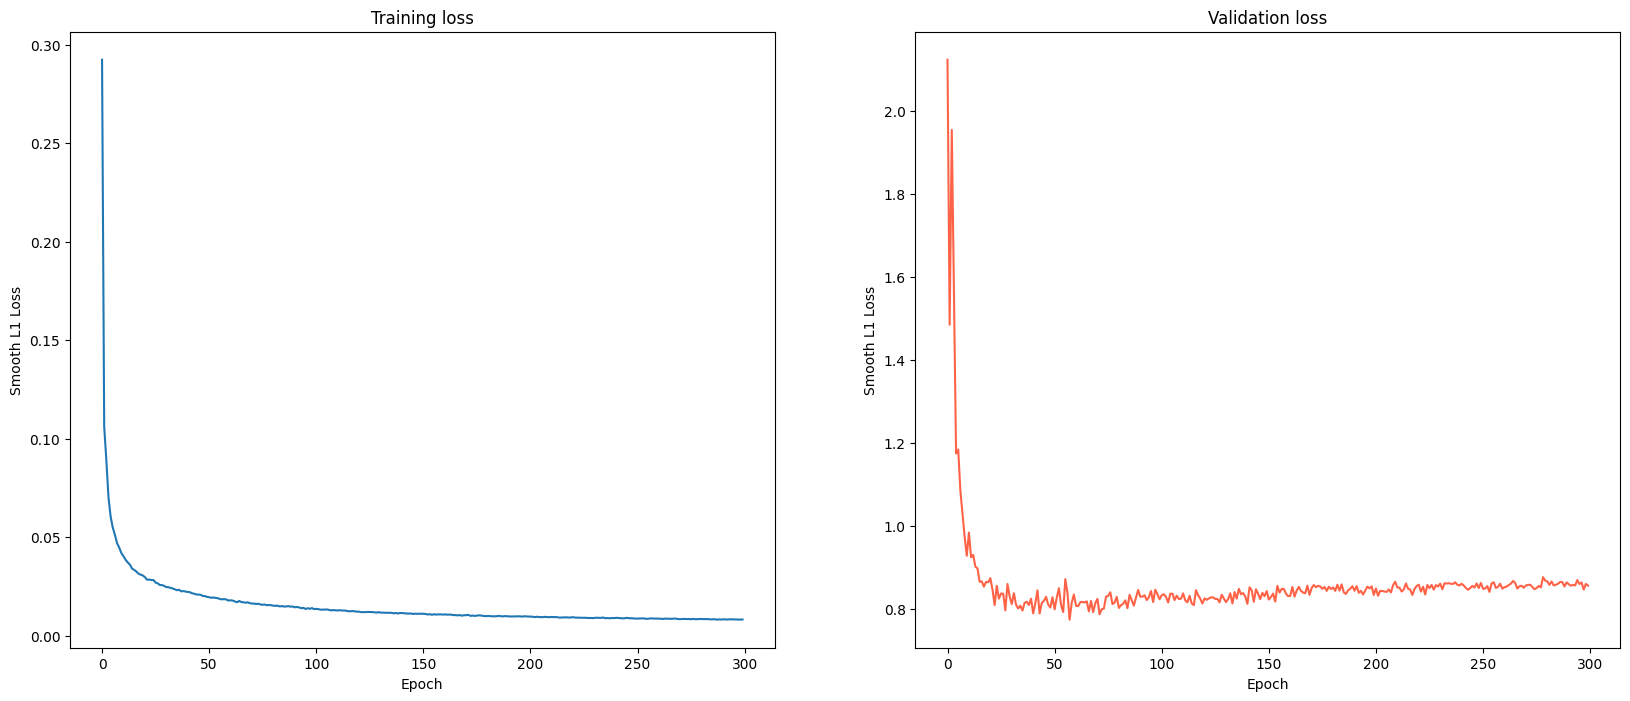

In [97]:
optimizer.param_groups[0]['lr']=0.0001

epoch_plot=[]
val_plot=[]
num_epochs=300
counter=0
teacher_forcing_rate=1.
for epoch in range(0, num_epochs):

    # Call train and validate 
    print("\nEpoch: {}/{}".format(epoch+1, num_epochs))
    
    curr_lr = float(optimizer.param_groups[0]['lr'])
    
    train_loss              = trainer.train(teacher_forcing_rate=teacher_forcing_rate)
    epoch_plot.append(train_loss)

    val_loss              = trainer.validate()

    val_plot.append(val_loss)

    teacher_forcing_rate=max(teacher_forcing_rate-0.05, 0.5)
    if teacher_forcing_rate<0.5:
      teacher_forcing_rate=0.9

    # trainer.teacher_forcing_ratio=max(trainer.teacher_forcing_ratio-0.05,0.1)
    scheduler.step()

    print("\tTrain Loss {:.04f}\t Learning Rate {:.07f}\t Validation Loss {:.04f}".format(train_loss, curr_lr, val_loss))

fig, ax=plt.subplots(1,2, figsize=(20,8))
# ax[0].plot(trainer.train_plot)
ax[0].plot(epoch_plot)
ax[0].set_ylabel("Smooth L1 Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_title("Training loss")

ax[1].plot(val_plot, color='tomato')
ax[1].set_ylabel("Smooth L1 Loss")
ax[1].set_xlabel("Epoch")
ax[1].set_title("Validation loss")


In [23]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [98]:
path="/content/drive/MyDrive/stockprices/checkpoint_ALL1.pth"
torch.save({'model_state_dict':trainer.model.state_dict(),
                  'optimizer_state_dict':trainer.optimizer.state_dict(),
                  'epoch': epoch}, path)

In [24]:
path="/content/drive/MyDrive/stockprices/checkpoint_ALL.pth"
checkpoint = torch.load(path)
model.load_state_dict(checkpoint['model_state_dict'])
trainer.model=model

### **# Testing: Generate each day's predictions**

In [99]:
#window size: 65, context_len:5, pred_len: 5 
prediction=trainer.test(test_loader)
prediction=[i.cpu().detach().numpy() for i in prediction]

In [101]:
print(prediction[0].shape)
len(prediction)

(1, 10, 10)


1973

In [102]:
gc.collect()
torch.cuda.empty_cache()
predictions=np.concatenate(prediction, axis=0)
print(predictions.shape)


(1973, 10, 10)


In [111]:
# plt.plot(predictions[:,0,0])
# plt.plot(np.array(dfs_standard)[0,:,3])

### **Scale back original Price**

In [104]:
prediction_back=[]
for i in range(len(dir)):
  sc=Scalers[i]
  prediction_i=predictions[:,0,i]
  prediction_i_padded=np.pad(prediction_i,(context_len+1, pred_len),'constant', constant_values=(prediction_i[0], prediction_i[-1]))
  dfs_copy=np.array(dfs.copy())[i]
  # print(dfs_copy.shape)
  dfs_copy[:,3]=prediction_i_padded
  inverse=sc.inverse_transform(dfs_copy)[:,3]
  prediction_back.append(inverse)

print(np.array(prediction_back).shape)

(10, 2014)


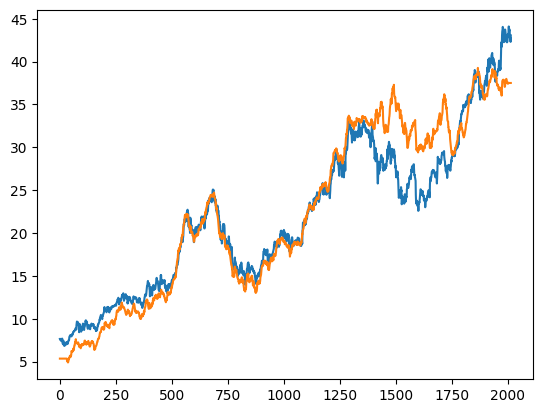

In [105]:
plt.plot(np.array(dfs)[0,:,3])
plt.plot(prediction_back[0])

### **Plot Predictions**

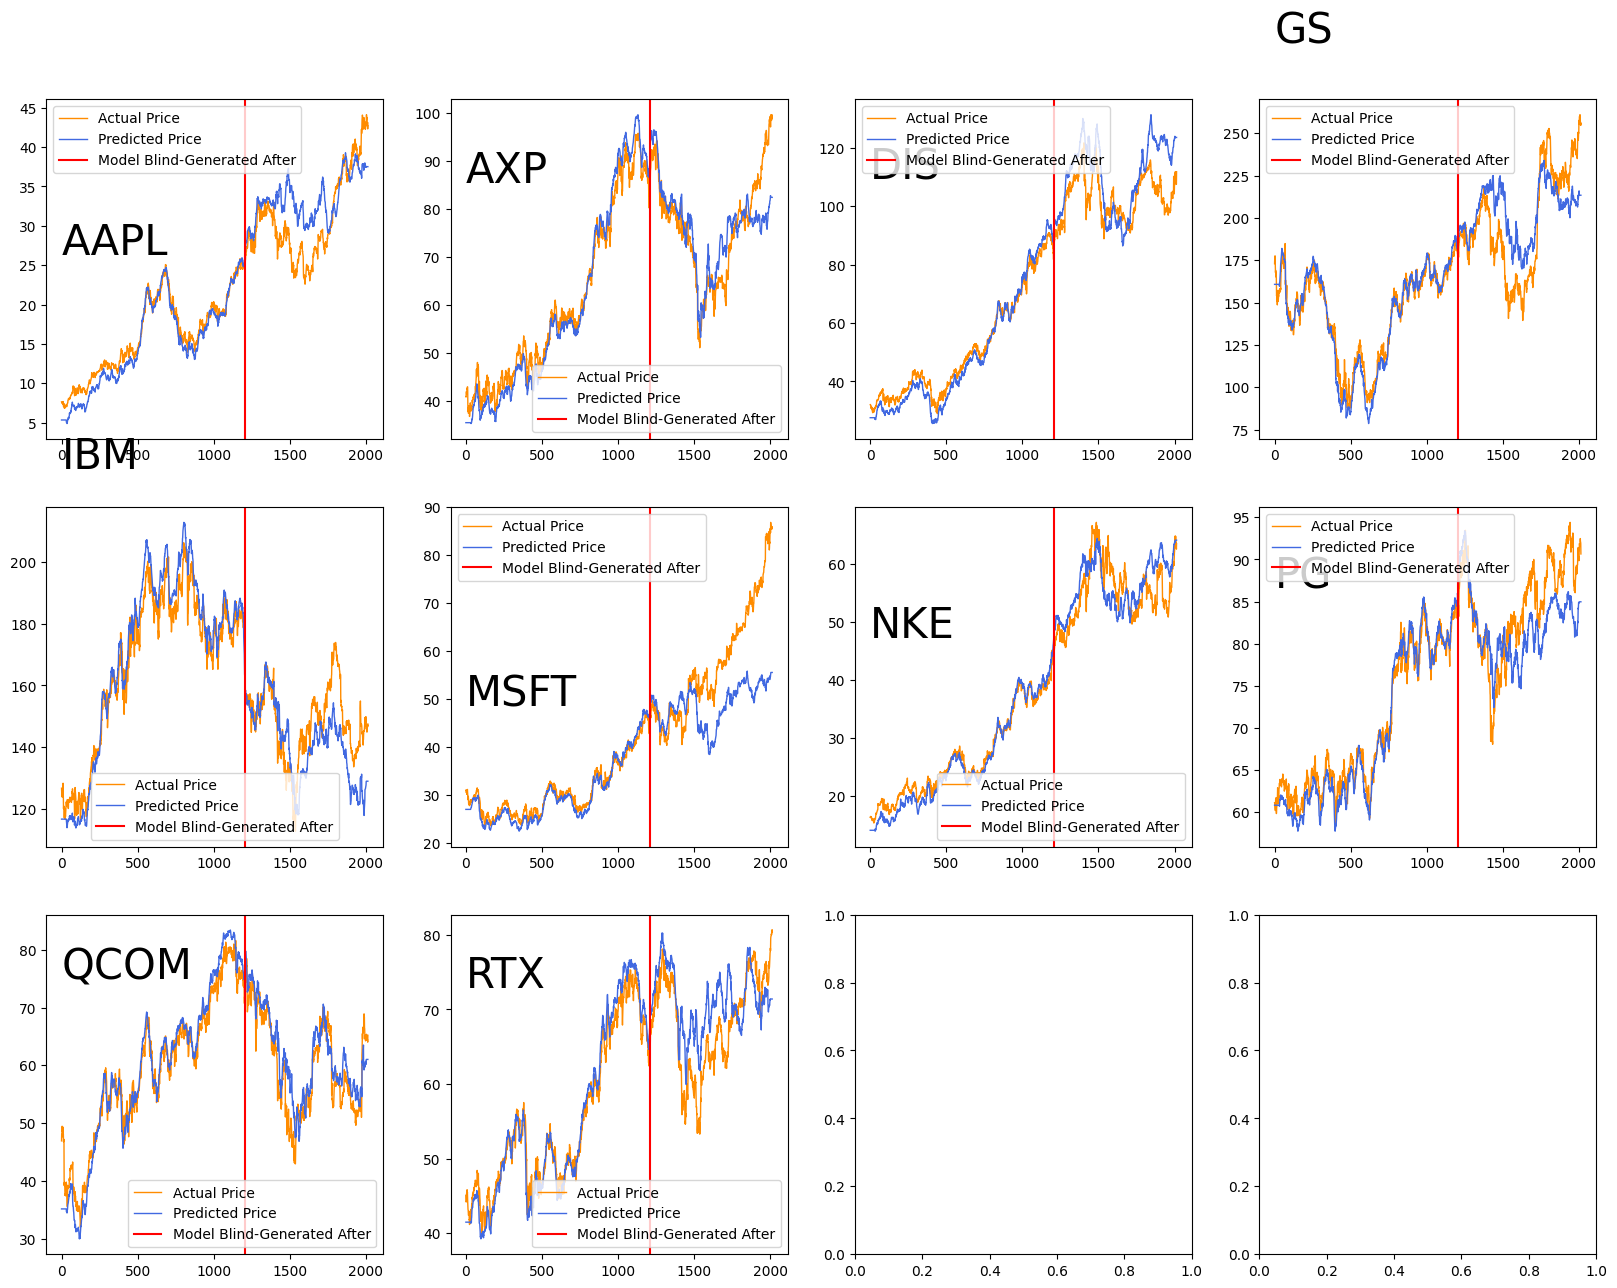

In [114]:
fig, ax=plt.subplots(3,4, figsize=(20,15))
ax=ax.ravel()
for i in range(len(dir)):
  ax[i].plot(np.array(dfs)[i,:,3], label='Actual Price', color='darkorange', linewidth=1)
  # ax[i].plot(np.array(actual_data)[:,7], label='Moving Average', color='cyan')
  # ax[i].bar(x=np.arange(0,len(dataset)), height=np.array(actual_data)[:,4]/5000000 , label='Volume', color='lightskyblue', alpha=0.3)

  ax[i].plot( prediction_back[i], label='Predicted Price',color='royalblue', linewidth=1)
  ax[i].axvline(x = int(dfs_cat.shape[0]*0.6), color='r', label="Model Blind-Generated After")
  ax[i].legend()
  # ax[i].xlabel("Days")
  # ax[i].ylabel("Prices")
  ax[i].annotate(dir[i],xy=(0, np.mean(prediction_back[i]) ),textcoords='offset points', fontsize=30)
  # ax[i].savefig("AAPL1.png", transparent = False)
plt.savefig("10Stocks", transparent = False)

### **Retrieve all predictions to feed in agent**

In [132]:
prediction_all=[]
for i in range(len(dir)):
  sc=Scalers[i]

  prediction_win=[]
  for j in range(pred_len):  #retieve all prediction each day
    prediction_i=predictions[:,j,i]
    prediction_i_padded=np.pad(prediction_i,(context_len+1, pred_len),'constant', constant_values=(prediction_i[0], prediction_i[-1]))
    dfs_copy=np.array(dfs.copy())[i]
    dfs_copy[:,3]=prediction_i_padded
    inverse=sc.inverse_transform(dfs_copy)[:,3]
    prediction_win.append( inverse)
  prediction_all.append(np.transpose(prediction_win))

print(np.array(prediction_all).shape)

(10, 2014, 10)


In [ ]:
plt.figure(figsize=(20,4))
prediction_all=np.array(prediction_all)
for i in range(len(prediction_all)):
  plt.plot(prediction_all[1,:,i], linewidth=0.5)

### **Store in Dataframe and toCSV**

In [147]:
dff=[]
for i in range(len(dir)):
  df_out=pd.DataFrame(prediction_all[i],  columns=np.arange(0, pred_len))
  df_out.to_csv(dir[i]+"_Pred.csv")
  dff.append(df_out)


In [150]:
dff[1]

,0,1,2,3,4,5,6,7,8,9
0,35.493279,35.208176,35.180599,35.057409,35.309897,35.183973,35.300179,35.122472,35.358141,35.328982
1,35.493279,35.208176,35.180599,35.057409,35.309897,35.183973,35.300179,35.122472,35.358141,35.328982
2,35.493279,35.208176,35.180599,35.057409,35.309897,35.183973,35.300179,35.122472,35.358141,35.328982
3,35.493279,35.208176,35.180599,35.057409,35.309897,35.183973,35.300179,35.122472,35.358141,35.328982
4,35.493279,35.208176,35.180599,35.057409,35.309897,35.183973,35.300179,35.122472,35.358141,35.328982
...,...,...,...,...,...,...,...,...,...,...
2009,82.467241,82.496466,82.890307,82.973953,82.757193,82.485916,82.504765,82.508340,83.313516,82.715934
2010,82.467241,82.496466,82.890307,82.973953,82.757193,82.485916,82.504765,82.508340,83.313516,82.715934
2011,82.467241,82.496466,82.890307,82.973953,82.757193,82.485916,82.504765,82.508340,83.313516,82.715934
2012,82.467241,82.496466,82.890307,82.973953,82.757193,82.485916,82.504765,82.508340,83.313516,82.715934


In [ ]:
# #window size: 65, context_len:5, pred_len: 5 
# pp=[]
# pbar = tqdm(total=800,desc="predicting...")
# for i in range(800):
#   query=dataset[context_len-1+i:window_size-1+i]
#   tar=torch.FloatTensor(query).unsqueeze(0).to(device)   #1,5, 9
#   src=torch.FloatTensor(dataset[0+i: context_len+i]).unsqueeze(0).to(device)   #1, 65,9

#   out=trainer.model(src,tar) 
#   o=out.cpu().detach().numpy()[0,1]  
#   pp.append(o)
#   pbar.update()
# pbar.close()
# pp=np.squeeze(pp)
# pp.shape

In [ ]:
# #0,'Time',1,'Open',2,'High',3,'Low',4,'Close',5,'Volume',6,'change',7,'delta',8,'Moving Average'
# plt.figure(figsize=(10,8))
# plt.plot(np.array(dataset)[:1100,4], label='Actual Price', color='darkorange', linewidth=1)
# plt.plot(np.array(dataset)[:1100,8], label='Moving Average', color='cyan')
# plt.bar(x=np.arange(0,1100), height=np.array(dataset)[:1100,5]/5, label='Volume', color='lightskyblue', alpha=0.3)
# plt.annotate("GOOGL",xy=(0.3,0.6),textcoords='offset points')
# plt.plot(np.arange(context_len,800+context_len), pp, label='Predicted Price',color='royalblue', linewidth=0.5)
# plt.legend()
# # plt.ylim(200,400)

In [ ]:
# import seaborn as sns

In [ ]:
# def test_for_agent( model, test_loader):
#       model.eval() # set to training mode
#       model.to(device)
#       batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
#       prediction=[]
#       for i, batch in enumerate(test_loader):
#           # self.optimizer.zero_grad()

#           src, trg, y_test = batch

#           src = src.to(device)
#           trg = trg.to(device)

#           batch_size = src.shape[0]

#           y_pred = model(src, trg, src_mask=None, tgt_mask=None)
#           prediction.append(y_pred[0])

#           #0,'Time',1,'Open',2,'High',3,'Low',4,'Close',5,'Volume',6,'change',7,'delta',8,'Moving Average'
#           del src, trg, y_test
#           torch.cuda.empty_cache()
#           batch_bar.update()

#       batch_bar.close()

#       return prediction

In [ ]:
# prediction=test_for_agent(model=trainer.model, test_loader=test_loader)
# prediction=[i.cpu().detach().numpy() for i in prediction]
# prediction

In [ ]:
# prediction=np.squeeze(np.array(prediction))
# prediction.shape

(1217, 10)

In [ ]:
# prediction=prediction[int(0.5*len(dataset)):]


In [ ]:
# pred_data=Scaler.inverse_transform(prediction)
# plt.plot(pred_data[:,0])

# Experiment

In [ ]:
# Login to Wandb
# Initialize your Wandb Run Here
# Save your model architecture in a txt file, and save the file to Wandb

In [ ]:
# Optional: Load your best model Checkpoint here

# TODO: Create a testing function similar to validation 
# TODO: Create a file with all predictions 
# TODO: Submit to Kaggle